In [71]:
include("LazyMatrices.jl")
include("TurtleSearch.jl")
# using .LazyMatrices, .TurtleSearch
import .LazyMatrices as lm
import .TurtleSearch as tt

In [149]:
include("eom.jl")
import .GoldbergerWiseEoM as eom
# using .GoldbergerWiseEoM

In [3]:
using Plots, LaTeXStrings

In [10]:
function g2_m_perturb(l2, xrange, u=eom.u, k=eom.k, yₘ=eom.yₘ)
    g2s0 = exp10.(range(xrange..., 100))
    m2s0 = 4l2*(2k+u)*u^2/(3k)*(1-exp(2k*yₘ))/(1-exp((4k+2u)*yₘ)) * (1 .- (4k+2u) ./g2s0)
    ms0 = sqrt.(m2s0)
    return g2s0, ms0
end

g2_m_perturb (generic function with 4 methods)

In [150]:
function nextpose!(poses, m)
    t = tt.Turtles(max(poses...))
    inds = tt.bisearch(t, m)
    xs = [m.xaxis(inds[1])]
    ys = [m.yaxis(inds[2])]
    while !isnothing(tt.next!(t, m))
        inds = tt.bisearch(t, m)
        push!(xs,m.xaxis(inds[1]))
        push!(ys,m.yaxis(inds[2]))
    end
    poses = tt.findfirstseed!(m, map(x->x+CartesianIndex(0,1), poses)...)
    return xs, ys
end
function g2_m_numerical(l2, xrange, yrange, u=eom.u, k=eom.k, φP=1e-1; logscaled = true, nSeeds = 1)
    paramsearch_g2_m = eom.paramsearch(l2=l2, φP=φP)
    m = lm.LazyMatrix(zeros(50,50), paramsearch_g2_m, xrange, yrange, logscaled = logscaled)
    poses = tt.findfirstseed!(m, CartesianIndex(1, 1), CartesianIndex(1, 2))
    @assert !isnothing(poses) "no seed found"
    g2_m = []
    for i = 1:nSeeds
        push!(g2_m, nextpose!(poses, m))
    end
    return g2_m
end

g2_m_numerical (generic function with 4 methods)

In [60]:
function getφ(m, l2, g2; FP=1., φP=1.)
    params = (m, l2, g2)
    Fsol = eom.solveODE(FP, φP, params)
    eom.getφ(Fsol, params)
end

getφ (generic function with 1 method)

In [ ]:
function axis_scale(x)
    if abs(x)<=1
        return x
    elseif x>1
        return 1+log10(x)
    elseif x<1
        return -1-log10(-x)
    end
end

axis_scale (generic function with 1 method)

In [151]:
g2_m = g2_m_numerical(1e-3, (0, 4), (-10, 1), eom.u, eom.k, -1e0, nSeeds=1)

(φP, dFP.(φP * [0.9, 1.1], FP, l², k, γ²)) = (-1.0, [7.400083333333333, 7.4001166666666665])


ErrorException: stop

φ(0) = -0.2500000000003056


φ(0) = -0.2500000000003056


φ(0) = -0.2500000000003056


φ(0) = -0.2500000000003056


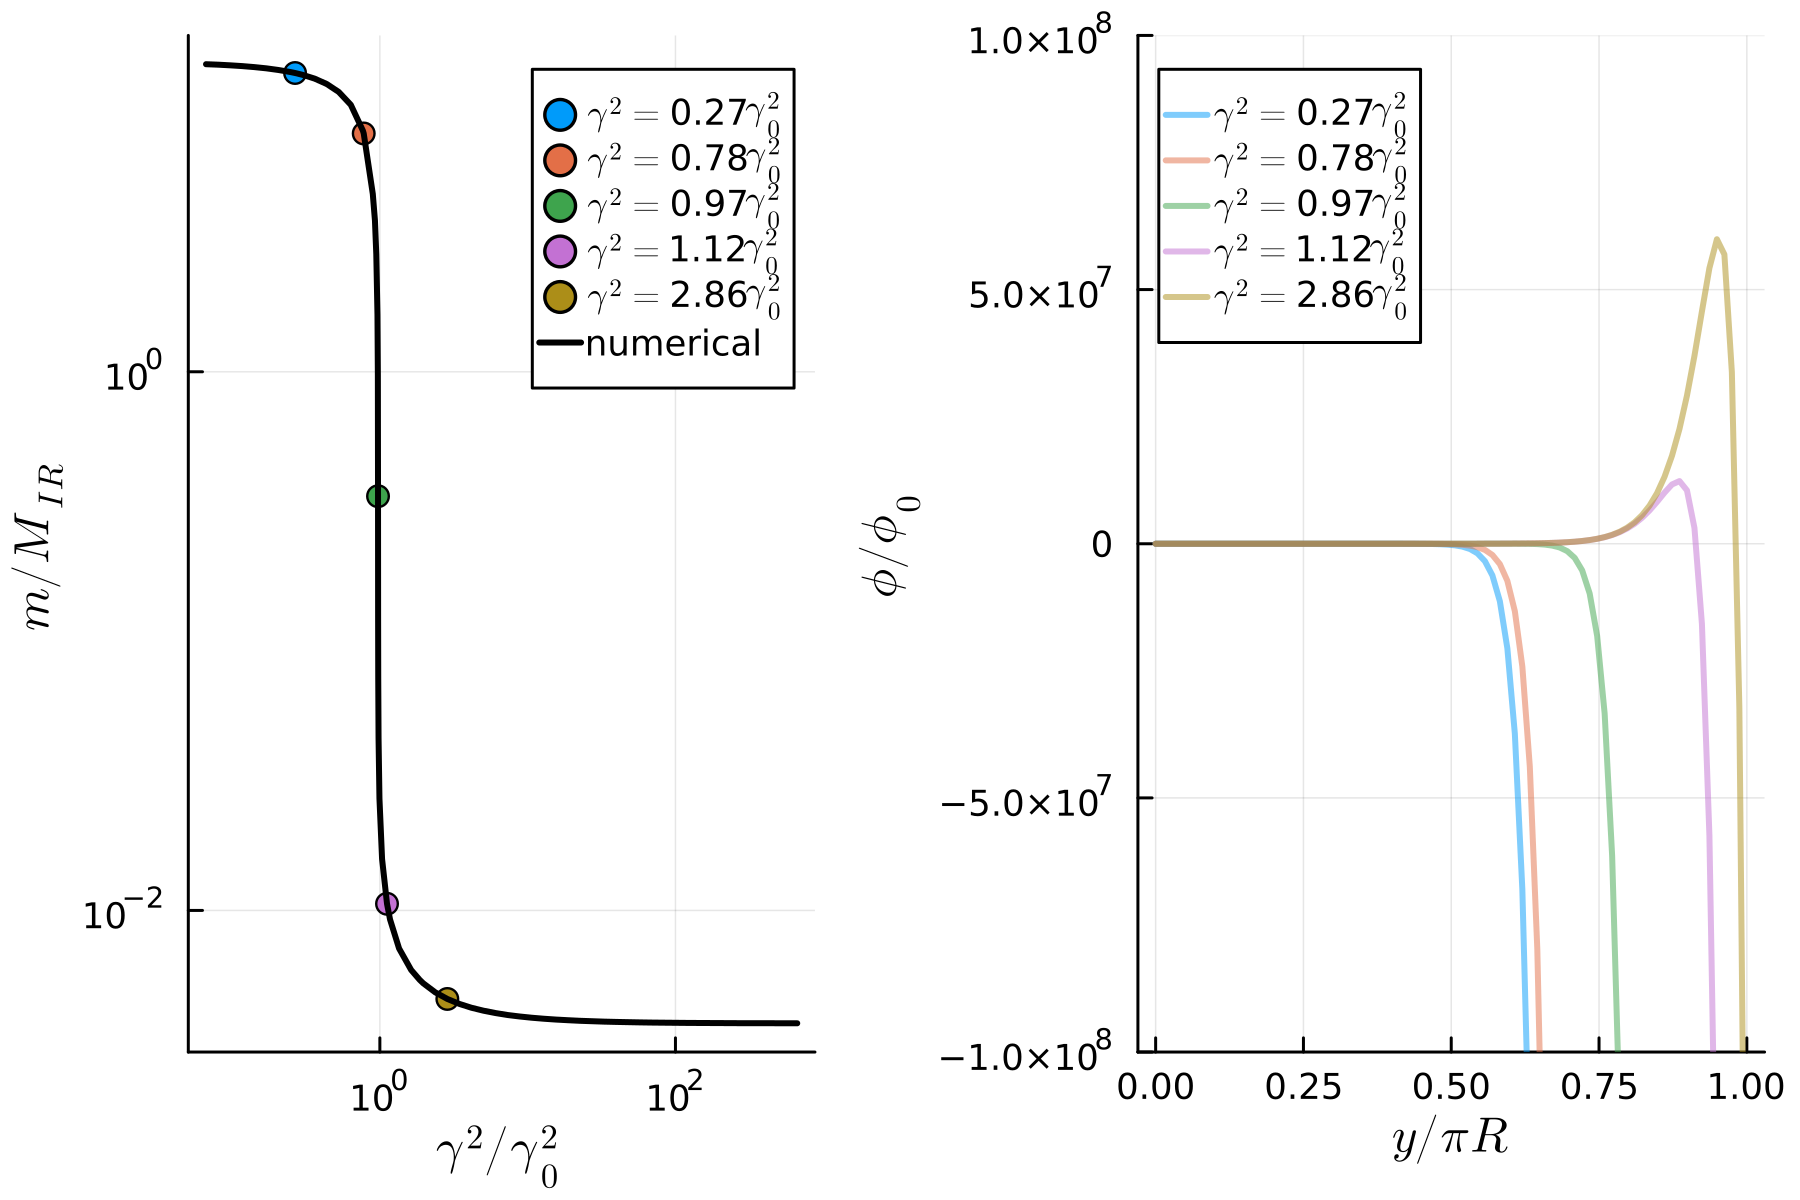

φ(0) = -0.2500000000003056

In [142]:
f1 = scatter()
f2 = plot(xlabel = L"y/\pi R", ylabel = L"\phi/\phi_0")
for (g2s, ms) in g2_m
    inds = findall(x-> 0.25eom.γ²₀ < x < 4eom.γ²₀, g2s)[1:7:end]
    
    for i in inds
        scatter!(f1, [g2s[i]/eom.γ²₀], [ms[i]/eom.M_IR], label = L"\gamma^2="*string(round(g2s[i]/eom.γ²₀, digits=2))*L"\gamma_0^2")
        φ(x) = getφ(ms[i], 1e-3, g2s[i])(x)
        @show φ(0)
        plot!(f2, x-> (φ(π*x)+eom.ϕ0(π*x))/eom.ϕP, range(0,1,80), label = L"\gamma^2="*string(round(g2s[i]/eom.γ²₀, digits=2))*L"\gamma_0^2", lw=2, alpha=0.5, ylim=(-1e8,1e8))
    end
end
plot!(f1, g2_m[1]./[eom.γ²₀, eom.M_IR]..., label = "numerical", xlabel = L"\gamma^2/\gamma^2_0", ylabel = L"m/M_{IR}", legend = :topright, xaxis=:log10, yaxis=:log10, lw=2, c=:black)
# plot!(f1, g2_m_perturb(1e-3, (log10(eom.γ²₀)*(1+1e-3), 4))./[eom.γ²₀, eom.M_IR]..., label = "perturbative", lw=2, c=:black, ls=:dash)
f = plot!(f1, f2, layout = (1,2), dpi=300)
display(f)

┌ Warning: scale asinh is unsupported with Plots.GRBackend().
│ Choose from: [:identity, :ln, :log10, :log2]
└ @ Plots C:\Users\Acer\.julia\packages\Plots\tDI0A\src\args.jl:1580
┌ Warning: scale asinh is unsupported with Plots.GRBackend().
│ Choose from: [:identity, :ln, :log10, :log2]
└ @ Plots C:\Users\Acer\.julia\packages\Plots\tDI0A\src\args.jl:1580
┌ Warning: scale asinh is unsupported with Plots.GRBackend().
│ Choose from: [:identity, :ln, :log10, :log2]
└ @ Plots C:\Users\Acer\.julia\packages\Plots\tDI0A\src\args.jl:1580
┌ Warning: scale asinh is unsupported with Plots.GRBackend().
│ Choose from: [:identity, :ln, :log10, :log2]
└ @ Plots C:\Users\Acer\.julia\packages\Plots\tDI0A\src\args.jl:1580


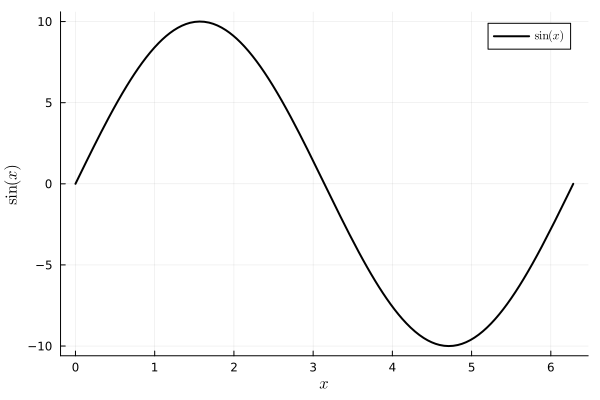

In [110]:
plot(x->10sin(x), 0, 2π, label = L"\sin(x)", xlabel = L"x", ylabel = L"\sin(x)", legend = :topright, lw=2, c=:black, scale=:asinh)